# Importer les packages

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Charger les données

La dernière colonne `Bug` est créée de manière aléatoire : elle prend la valeur 1 si il y a un bug et 0 sinon.

In [76]:
data = pd.read_csv('filtered_final_metrics.csv')
data['Bug'] = data['AvgCountLine']//10%2
liste = ['CCViolDensityLine','CCViolDensityCode','RatioCommentToCode']
for elm in liste:
    data[elm] = data[elm].str.replace(',', '.').astype(float)
data.head(5)

,Version,CommitId,Name,AvgCountLine,AvgCountLineBlank,AvgCountLineCode,AvgCountLineComment,AvgCyclomatic,CountClassBase,CountClassCoupled,...,CountDeclMethodConst,CountDeclMethodFriend,CountLineInactive,CountLinePreprocessor,CountStmtEmpty,CountCCViol,CountCCViolType,CCViolDensityLine,CCViolDensityCode,Bug
0,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTBuilder.java,13,0,12,0,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1
1,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTConverter.java,17,1,14,2,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1
2,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTNode.java,10,1,8,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1
3,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ATSHook.java,15,1,14,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1
4,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,AbstractFileMergeOperator.java,20,1,16,4,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0


# Préparation des variables
Modifier les variables indépendantes en fonction de la table. On ne prend pas en compte la version et l'id des commits dans le modèle.

In [77]:
X = data.drop(columns=['Bug','Version','CommitId', 'Name']) # variables indépendantes
X = X.dropna(axis=1)
y = data['Bug'] # présence d'un bug

# Données d'entraînements et de test
Modifier test_size à **0.2** pour 20% de test, et 80% de train

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)
print(X_train.dtypes)

AvgCountLine             int64
AvgCountLineBlank        int64
AvgCountLineCode         int64
AvgCountLineComment      int64
AvgCyclomatic            int64
CountDeclClass           int64
CountDeclFunction        int64
CountLine                int64
CountLineBlank           int64
CountLineCode            int64
CountLineCodeDecl        int64
CountLineCodeExe         int64
CountLineComment         int64
CountSemicolon           int64
CountStmt                int64
CountStmtDecl            int64
CountStmtExe             int64
MaxCyclomatic            int64
MaxNesting               int64
RatioCommentToCode     float64
SumCyclomatic            int64
CountCCViol              int64
CountCCViolType          int64
CCViolDensityLine      float64
CCViolDensityCode      float64
dtype: object


# Entrainement du modèle

In [79]:
model1 = LogisticRegression()
model2 = RandomForestClassifier(n_estimators=100, random_state=42)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

print(y_train.value_counts())

Bug
0    225
1    210
Name: count, dtype: int64


C:\Users\yanth\VSCodeProjects\MGL869-Lab-Hive\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Prédictions

In [80]:
y_pred1 = model1.predict(X_test)
print("Prédictions logistic regression :", y_pred1)
print("Valeurs réelles :", y_test.values)
y_pred2 = model2.predict(X_test)
print("Prédictions random forest :", y_pred2)
print("Valeurs réelles :", y_test.values)

Prédictions logistic regression : [0 1 1 ... 0 0 1]
Valeurs réelles : [0 0 1 ... 1 0 1]
Prédictions random forest : [0 0 0 ... 1 0 1]
Valeurs réelles : [0 0 1 ... 1 0 1]


In [81]:
# Calcul de l'AUC pour chaque modèle
auc1 = roc_auc_score(y_test, y_pred1)
auc2 = roc_auc_score(y_test, y_pred2)
print(auc1)
print(auc2)

0.6139311666006078
0.9478854538248118


# Evaluer la performance du modèle

In [82]:
accuracy = accuracy_score(y_test, y_pred1)
print(f"Accuracy logistic regression: {accuracy}")
print(classification_report(y_test, y_pred1))
print(f"AUC Logistic Regression: {auc1}")
print("-"*60)

accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy random forest: {accuracy}")
print(classification_report(y_test, y_pred2))
print(f"AUC Random Forest: {auc2}")

Accuracy logistic regression: 0.6122917863296956
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       900
           1       0.59      0.66      0.62       841

    accuracy                           0.61      1741
   macro avg       0.61      0.61      0.61      1741
weighted avg       0.62      0.61      0.61      1741

AUC Logistic Regression: 0.6139311666006078
------------------------------------------------------------
Accuracy random forest: 0.9477311889718553
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       900
           1       0.94      0.95      0.95       841

    accuracy                           0.95      1741
   macro avg       0.95      0.95      0.95      1741
weighted avg       0.95      0.95      0.95      1741

AUC Random Forest: 0.9478854538248118


In [72]:
print("Indices de X_train :", X_train.index)
print("Indices de X_test :", X_test.index)

Indices de X_train : Index([ 603,  776, 1008,  730, 1817,   47, 1482, 1035, 1751,  845,
       ...
        629,  373, 2134, 1271, 1122, 1267,  958, 1802,  440,  338],
      dtype='int64', length=435)
Indices de X_test : Index([1111,  396,   93, 1816, 1896, 2062, 1004, 1642, 1121, 1473,
       ...
        307, 1804,  430, 1509,  622, 2165, 1490, 1244, 1134,  931],
      dtype='int64', length=1741)


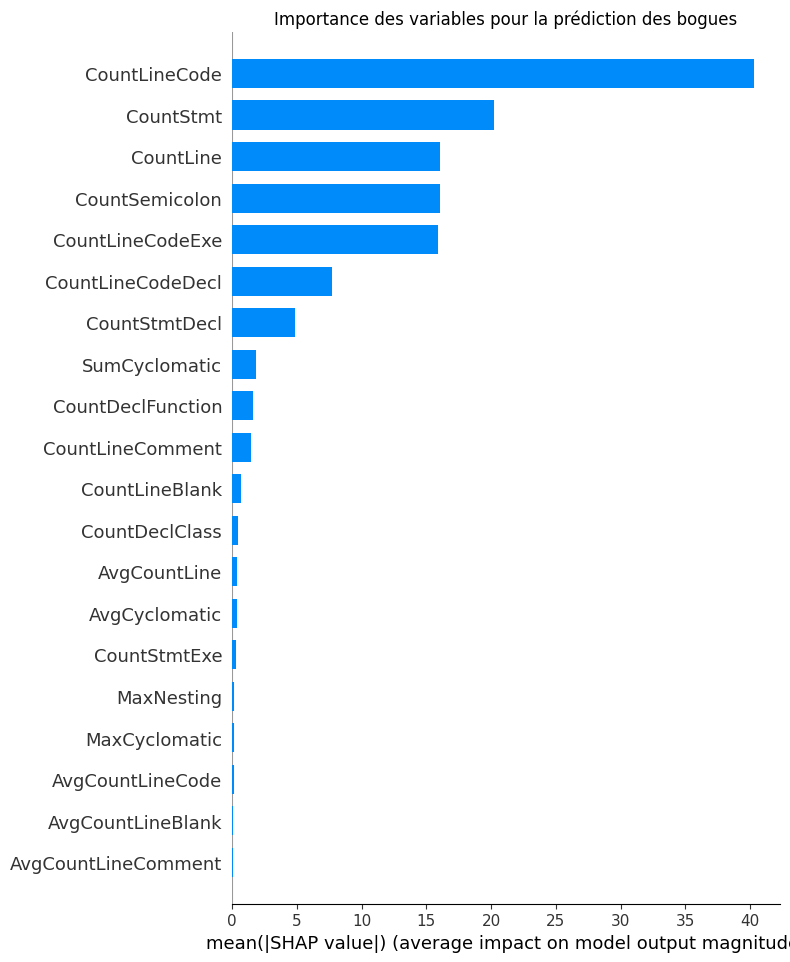

In [74]:
# Calculer les valeurs SHAP pour obtenir l'importance des variables
explainer = shap.Explainer(model1, X_train)
shap_values = explainer(X_test)

# Visualiser l'importance des variables avec un nomogramme
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importance des variables pour la prédiction des bogues")
plt.savefig('mon_graphique.png')
plt.show()

In [75]:
X = data[['CountLineCode','CountStmt','CountStmtExe', 'CountLine', 'SumCyclomatic']] # variables indépendantes
y = data['Bug'] # présence d'un bug
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy random forest: {accuracy}")
print(classification_report(y_test, y_pred2))
print(f"AUC Random Forest: {auc2}")

Accuracy random forest: 0.9477311889718553
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       900
           1       0.94      0.95      0.95       841

    accuracy                           0.95      1741
   macro avg       0.95      0.95      0.95      1741
weighted avg       0.95      0.95      0.95      1741

AUC Random Forest: 0.9478854538248118
